<a href="https://colab.research.google.com/github/SemanticComputing/parliamentsampo-mention-networks/blob/main/comention_content.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Co-mention and bibliographical coupling networks

Based on similarities of sentences that contain person name mentions.

## Libraries

In [2]:
import codecs

from collections import defaultdict, OrderedDict, Counter
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from itertools import product, combinations, chain

import matplotlib.pyplot as plt
from matplotlib import cm, colors

import networkx as nx
from networkx.algorithms import community
import numpy as np
import scipy as sp

import pandas as pd
import re
from scipy.interpolate import interp1d
from scipy.signal import convolve2d
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, minmax_scale
import sys
from typing import Dict, List, Set, Tuple, Type, Union


## Functions


In [3]:
from scipy.stats import rankdata

# Set properties for the nodes

def set_stats_and_ranks(G, dct, prop = 'degree', cond = (lambda x: x>0)):
  arr = sorted(dct, key=lambda x: x[-1], reverse=True)

  for (k,v), r in zip(arr, rankdata([-v for _,v in arr], method='min')):
    if cond(v):
      # NB exporting to graphml does not support dictionaries as property values
      # G.nodes[k][prop] = {'value': v, 'rank': r} will cause an error
      G.nodes[k][prop] = v

def checkDate(v):
  try:
    d = datetime.strptime(v, '%Y-%m-%dT%H:%M:%S').date()
  except ValueError:
    '''
    cases e.g. 29th february of a non-loop year
    '''
    m = re.match(r'(\d{4})-(\d{2})-(\d{2})', v)
    d = datetime(int(m.groups()[0]), int(m.groups()[1]), 28).date()
  return d

In [4]:
def drawGraph(G,
              pos=None,
              node_color='#1f78b4',
              edge_color='grey',
              size_scale = [400,2000],
              node_size='degree',
              cmap = plt.get_cmap('viridis'),
              labels = None,
              font_size = 20,
              weight='weight',
              gov_legend=False,
              min_e = None,
              max_e = None):
  if pos is None:
    print("Adjusting layout ...")
    pos = nx.drawing.layout.fruchterman_reingold_layout(G, iterations=200)

  fig = plt.figure(figsize=[40.0, 24.0])
  ax = fig.add_subplot(111)

  # set node size by the pagerank, and scale it to range [50,...]
  nodesizes = [e.get(node_size, 1) for _,e in G.nodes(data=True)]

  # If all the nodes have same size set constant size else scale sizes to scale_size scale
  if len(set(nodesizes)) == 1:
    nodesize = max(size_scale)
  else:
    scale_size = interp1d([min(nodesizes),max(nodesizes)], size_scale)
    nodesize = scale_size(nodesizes)

  edge_weights = [e.get(weight,1) for _,_,e in G.edges(data=True)]
  if min_e is None and max_e is None:
    scale_weight =  interp1d([min(edge_weights),max(edge_weights)],[1,20])
  else:
    scale_weight =  interp1d([min_e,max_e],[1,20])
  nx.drawing.draw_networkx_edges(G,
                                width=scale_weight(edge_weights),
                                pos=pos,
                                alpha=0.4,
                                edge_color=edge_color,
                                connectionstyle='arc3, rad = 0.05',
                                node_size=nodesize
                                )



  nx.drawing.draw_networkx_nodes(G,
                                pos=pos,
                                node_size=nodesize,
                                node_color = node_color,
                                #edgecolors = 'black',
                                cmap = cmap,
                                alpha=0.8
                                )

  if labels:
    nx.drawing.draw_networkx_labels(G,
                              pos=pos,
                              font_size = font_size,
                              labels = labels)

  if gov_legend:
    plt.scatter([],[], c='#0F4DBC', label='Hallitus')
    plt.scatter([],[], c='#BF1E24', label='Oppositio')
    plt.legend(prop={'size': font_size})

  plt.show()
  return pos

## Data

In [5]:
df_mentions = pd.read_csv('/content/mention_sentences_2015-04-22_2019-04-16.csv', sep=';')
print("Number of mentions", len(df_mentions))
df_mentions.head()

Number of mentions 40677


,speech,source,target,date,mention,og_sentence,lem_sentence,misses
0,http://ldf.fi/semparl/speeches/s2016_1_069_097,http://ldf.fi/semparl/people/p1338,http://ldf.fi/semparl/people/p1341,2016-06-15,kurvinen,Edustaja Kurvinen tuossa lainsäädännön aukotto...,lainsäädäntö aukottomuus puhua haluta tietää t...,0
1,http://ldf.fi/semparl/speeches/s2018_1_125_099,http://ldf.fi/semparl/people/p856,http://ldf.fi/semparl/people/p1106,2018-12-04,savolan,Kilometrirajoista — edustaja Savolan toinen ky...,kilometriraja toinen kysymys valiokunta kannat...,0
2,http://ldf.fi/semparl/speeches/s2018_1_125_099,http://ldf.fi/semparl/people/p856,http://ldf.fi/semparl/people/p1106,2018-12-04,savola,Edustaja Savola aloitti erinomaisella kysymyks...,aloittaa erinomainen kysymys bulvaanikauppa,0
3,http://ldf.fi/semparl/speeches/s2018_1_027_072,http://ldf.fi/semparl/people/p1341,http://ldf.fi/semparl/people/p582,2018-03-22,leppä,"On hyvä kuulla, että asiasta vastaava minister...",hyvä kuultaa asia vastaava tarttunut asia vira...,0
4,http://ldf.fi/semparl/speeches/s2018_1_130_117,http://ldf.fi/semparl/people/p971,http://ldf.fi/semparl/people/p583,2018-12-13,lintilän,Ministeri Lintilän asettaman ohjausryhmän ehdo...,asettaa ohjausryhmä ehdotus suomi tekoälyohjel...,1


In [6]:
for row in df_mentions.iterrows():
  row[1]['date'] = checkDate(row[1]['date'])
df_mentions.head()

,speech,source,target,date,mention,og_sentence,lem_sentence,misses
0,http://ldf.fi/semparl/speeches/s2016_1_069_097,http://ldf.fi/semparl/people/p1338,http://ldf.fi/semparl/people/p1341,2016-06-15,kurvinen,Edustaja Kurvinen tuossa lainsäädännön aukotto...,lainsäädäntö aukottomuus puhua haluta tietää t...,0
1,http://ldf.fi/semparl/speeches/s2018_1_125_099,http://ldf.fi/semparl/people/p856,http://ldf.fi/semparl/people/p1106,2018-12-04,savolan,Kilometrirajoista — edustaja Savolan toinen ky...,kilometriraja toinen kysymys valiokunta kannat...,0
2,http://ldf.fi/semparl/speeches/s2018_1_125_099,http://ldf.fi/semparl/people/p856,http://ldf.fi/semparl/people/p1106,2018-12-04,savola,Edustaja Savola aloitti erinomaisella kysymyks...,aloittaa erinomainen kysymys bulvaanikauppa,0
3,http://ldf.fi/semparl/speeches/s2018_1_027_072,http://ldf.fi/semparl/people/p1341,http://ldf.fi/semparl/people/p582,2018-03-22,leppä,"On hyvä kuulla, että asiasta vastaava minister...",hyvä kuultaa asia vastaava tarttunut asia vira...,0
4,http://ldf.fi/semparl/speeches/s2018_1_130_117,http://ldf.fi/semparl/people/p971,http://ldf.fi/semparl/people/p583,2018-12-13,lintilän,Ministeri Lintilän asettaman ohjausryhmän ehdo...,asettaa ohjausryhmä ehdotus suomi tekoälyohjel...,1


In [7]:
df_mentions.loc[df_mentions['target'] == 'http://ldf.fi/semparl/people/p1146']

,speech,source,target,date,mention,og_sentence,lem_sentence,misses
33,http://ldf.fi/semparl/speeches/s2017_1_036_032,http://ldf.fi/semparl/people/p947,http://ldf.fi/semparl/people/p1146,2017-04-06,lindström,Sen lisäksi työ- ja elinkeinoministeriöllä on ...,lisä elinkeinoministeriö pitkä lista yritystoi...,0
41,http://ldf.fi/semparl/speeches/s2016_1_135_157,http://ldf.fi/semparl/people/p809,http://ldf.fi/semparl/people/p1146,2016-12-15,lindströmin,"Täällä kysyttiin kotouttamisesta, ja mieluusti...",kysyä kotouttaa mieluusti vastainen sektori te...,1
110,http://ldf.fi/semparl/speeches/s2015_1_038_078,http://ldf.fi/semparl/people/p507,http://ldf.fi/semparl/people/p1146,2015-09-23,lindström,"Ministeri Lindström oli kai pyytänyt, vaatinut...",kai pyytänyt vaatinut ehdottanut miljoona pien...,1
114,http://ldf.fi/semparl/speeches/s2016_1_087_447,http://ldf.fi/semparl/people/p797,http://ldf.fi/semparl/people/p1146,2016-09-21,lindström,Ministeri Lindström on tässä tehnyt valtavia e...,tehnyt valtava edistysaskel muassa pitkä työtö...,0
117,http://ldf.fi/semparl/speeches/s2016_1_020_023,http://ldf.fi/semparl/people/p1126,http://ldf.fi/semparl/people/p1146,2016-03-08,lindströmille,Ensinnäkin kiitoksia ministeri Lindströmille h...,ensin kiitos hyvä vastaus,0
...,...,...,...,...,...,...,...,...
40502,http://ldf.fi/semparl/speeches/s2017_1_145_153,http://ldf.fi/semparl/people/p1128,http://ldf.fi/semparl/people/p1146,2017-12-19,lindström,Ministeri Lindström ei ole puolustamassa pelkä...,puolustaa pelkästään yksi asia kokonaisuus kym...,0
40551,http://ldf.fi/semparl/speeches/s2016_1_010_138,http://ldf.fi/semparl/people/p1276,http://ldf.fi/semparl/people/p1146,2016-02-18,lindström,Olemme käyneet täällä salissa erittäin mielenk...,käynyt sali erittäin mielenkiintoinen keskuste...,0
40573,http://ldf.fi/semparl/speeches/s2017_1_114_076,http://ldf.fi/semparl/people/p1323,http://ldf.fi/semparl/people/p1146,2017-11-08,lindströmin,Nostin äskeisessä puheenvuorossa tuon työttömy...,nostaa äskeinen puheenvuoro työttömyysturvalak...,2
40632,http://ldf.fi/semparl/speeches/s2017_1_027_092,http://ldf.fi/semparl/people/p1154,http://ldf.fi/semparl/people/p1146,2017-03-22,lindströmin,Edustaja edellä vei oikeastaan niin sanotusti ...,edeltää viedä oikea sanottu jalka suu tosi tär...,0


In [8]:
# List of MPs that are not in the 100 most mentioned MPs
tbr1 = df_mentions['target'].value_counts(ascending=False).index.tolist()[100:]

In [9]:
# List of MPs that are not in the top 100 most mentions made
tbr2 = df_mentions['source'].value_counts(ascending=False).index.tolist()[100:]

In [10]:
df_people = pd.read_csv('/content/people_2015-04-22_2019-04-16.csv', sep=';', index_col=0)
print(len(df_people))
df_people.head()

213


,name,party,date,color
http://ldf.fi/semparl/people/p1116,"Tolppanen, Maria",Suomen Sosialidemokraattinen Puolue,2016-06-23,#E11931
http://ldf.fi/semparl/people/p573,"Keränen, Niilo",Suomen Keskusta,1999-03-24,#01954B
http://ldf.fi/semparl/people/p1094,"Eestilä, Markku",Kansallinen Kokoomus,2011-04-20,#00587C
http://ldf.fi/semparl/people/p1088,"Mäntylä, Hanna",Korjausliike,2017-06-13,#0F4DBC
http://ldf.fi/semparl/people/p1108,"Sipilä, Juha",Suomen Keskusta,2011-04-20,#01954B


In [11]:
df_people.loc[['http://ldf.fi/semparl/people/p1146']]

,name,party,date,color
http://ldf.fi/semparl/people/p1146,"Lindström, Jari",Korjausliike,2017-06-13,#0F4DBC


## Create directed mention network

In [12]:
government = ['Suomen Keskusta', 'Kansallinen Kokoomus', 'Korjausliike']

In [13]:
G = nx.DiGraph()

for row in df_people.iterrows():
  if row[1]['party'] in government:
    gcolor = 'lightblue'
  elif row[1]['party'] == 'Perussuomalaiset':
    gcolor = 'yellow'
  else:
    gcolor = 'lightcoral'
  G.add_node(row[0], name=row[1]['name'], party=row[1]['party'], color=row[1]['color'], gcolor=gcolor)

print(len(G.nodes()))

213


In [14]:

for index, row in df_mentions.iterrows():
  if row['source'] in G.nodes and row['target'] in G.nodes:
    if row['og_sentence'] != 'missing':
      try:
        l1 = len(row['lem_sentence']) > 3
      except:
        print(row['lem_sentence'])
        print(row['og_sentence'])
      if G.has_edge(row['source'], row['target']):
        G.edges[row['source'], row['target']]['sentences'].append(row['lem_sentence'])
        G.edges[row['source'], row['target']]['weight'] += 1
      else:
        G.add_edge(row['source'], row['target'], sentences=[row['lem_sentence']], weight=1)




In [15]:
nx.density(G)

0.29123483036584286

In [16]:
ts = 0
pv_s = 0
puhe_s = 0
ps = 0
for n1,n2,d in G.edges(data=True):
  for s in d['sentences']:
    if "puheenvuoro" in s:
      pv_s += 1
      ps += 1
    if "puhe" in s:
      puhe_s += 1
      ps += 1
    ts += 1

print("Total number of sentences containing MP mentions:", ts)
print("Including 'puheenvuoro':", pv_s)
print("Including 'puhe':", puhe_s)
print(pv_s / ts)
print(ps/ts)

Total number of sentences containing MP mentions: 40634
Including 'puheenvuoro': 4770
Including 'puhe': 6069
0.11738937835310331
0.266747059113058


In [17]:
dct = G.in_degree(weight='weight')
set_stats_and_ranks(G, dct, 'in_degree')

arr = sorted(dct, key=lambda x: x[-1], reverse=True)
for v,u in arr[:15]:
  print(u, G.nodes[v])

1894 {'name': 'Sipilä, Juha', 'party': 'Suomen Keskusta', 'color': '#01954B', 'gcolor': 'lightblue', 'in_degree': 1894}
1401 {'name': 'Orpo, Petteri', 'party': 'Kansallinen Kokoomus', 'color': '#00587C', 'gcolor': 'lightblue', 'in_degree': 1401}
1117 {'name': 'Zyskowicz, Ben', 'party': 'Kansallinen Kokoomus', 'color': '#00587C', 'gcolor': 'lightblue', 'in_degree': 1117}
975 {'name': 'Lindström, Jari', 'party': 'Korjausliike', 'color': '#0F4DBC', 'gcolor': 'lightblue', 'in_degree': 975}
887 {'name': 'Heinonen, Timo', 'party': 'Kansallinen Kokoomus', 'color': '#00587C', 'gcolor': 'lightblue', 'in_degree': 887}
851 {'name': 'Soini, Timo', 'party': 'Korjausliike', 'color': '#0F4DBC', 'gcolor': 'lightblue', 'in_degree': 851}
825 {'name': 'Rinne, Antti', 'party': 'Suomen Sosialidemokraattinen Puolue', 'color': '#E11931', 'gcolor': 'lightcoral', 'in_degree': 825}
746 {'name': 'Heinäluoma, Eero', 'party': 'Suomen Sosialidemokraattinen Puolue', 'color': '#E11931', 'gcolor': 'lightcoral', 'in_de

Calculate number of different words for each MP in sentences MP has been mentioned and in sentences MP has mentioned some other MP


In [66]:
for node in G.nodes():
  bow_in = {}
  bow_out = {}

  for _,_,d in G.in_edges(nbunch=node, data=True):
    sentences = d['sentences']
    for s in sentences:
      s = s.split(" ")
      for w in s:
        if w not in bow_in and w != '':
          bow_in[w] = 1
        elif w in bow_in:
          bow_in[w] += 1

  for _,_,d in G.out_edges(nbunch=node, data=True):
    sentences = d['sentences']
    for s in sentences:
      s = s.split(" ")
      for w in s:
        if w not in bow_out and w != '':
          bow_out[w] = 1
        elif w in bow_out:
          bow_out[w] += 1

  G.nodes[node]['bow_in'] = bow_in
  G.nodes[node]['bow_out'] = bow_out



In [67]:
"""
# remove nodes until every remaining node has degree at least mlimit
mlimit = 100
while True:
  removed = []
  for n,d in G.nodes(data=True):
    if d['in_degree'] < mlimit:
      removed.append(n)
  if len(removed) == 0:
    break
  G.remove_nodes_from(removed)
  dct = G.in_degree(weight='weight')
  set_stats_and_ranks(G, dct, 'in_degree')


print(len(G.nodes()))
arr = sorted(dct, key=lambda x: x[-1], reverse=True)
for v,u in arr[:15]:
  print(u, v, G.nodes[v]['name'])
"""

cc = False # if True -> co-mention graph, else bibliographical coupling graph

# Remove MPs that are the least mentioned (tbr1, co-mention graph) or MPs that have made the least mentions (tbr2, bibliographical coupling graph)
if cc:
  G.remove_nodes_from(tbr1)
else:
  G.remove_nodes_from(tbr2)

In [68]:
person = 'http://ldf.fi/semparl/people/p967'
p_in_words = G.nodes[person]['bow_in']
arr = sorted(p_in_words.items(), key=lambda item: item[1], reverse=True)
print("Most frequent words in in-coming mention sentences (from 100 MPs that have made the largest number of mentions):")
for w, n in arr[:30]:
  print(n,w)

Most frequent words in in-coming mention sentences (from 100 MPs that have made the largest number of mentions):
104 puheenvuoro
100 asia
88 hyvä
76 esillä
70 sanoa
69 todeta
67 hallitus
65 tosi
61 tulla
59 kuten
54 tehdä
53 ottaa
48 keskustelu
48 kysymys
48 aivan
47 mieli
47 aika
46 osa
46 puhua
45 suomi
44 esimerkki
44 sama
43 saada
43 hyvin
42 pitää
41 haluta
40 tapa
36 voi
36 kysyä
35 vuosi


In [69]:
p_out_words = G.nodes[person]['bow_out']
arr = sorted(p_out_words.items(), key=lambda item: item[1], reverse=True)
print("Most frequent words in out-going mention sentences (to 100 most mentioned MPs):")
for w, n in arr[:30]:
  print(n,w)

Most frequent words in out-going mention sentences (to 100 most mentioned MPs):
164 esillä
164 hyvä
150 asia
122 pitää
121 hallitus
120 kiitos
115 aika
107 haluta
102 tehdä
92 tuoda
91 tulla
89 silta
85 saada
84 antaa
83 kysyä
82 mieli
78 esitys
75 puheenvuoro
75 esimerkki
71 tapa
71 yksi
69 eduskunta
63 todeta
60 voida
60 kertoa
56 työ
55 vuosi
55 nostaa
54 paikka
53 tilanne


## Create co-citation network or bibliographical coupling network

In [ ]:
def cosine_similarity(s1,s2):
  # Cosine similarity between two sentences
  words1 = {}
  for w in s1.split(" "):
    if w != '':
      if w not in words1:
        words1[w] = 1
      else:
        words1[w] += 1
  words2 = {}
  for w in s2.split(" "):
    if w != '':
      if w not in words2:
        words2[w] = 1
      else:
        words2[w] += 1

  l1 = []
  l2 = []
  wvector = set(words1.keys()).union(set(words2.keys()))

  for w in wvector:
    if w in words1:
      l1.append(words1[w]) # create a vector
    else:
      l1.append(0)
    if w in words2:
      l2.append(words2[w])
    else:
      l2.append(0)
  c1 = 0
  c2 = 0
  c3 = 0

  # cosine formula
  for i in range(len(wvector)):
    c1 += l1[i]*l2[i]
    c2 += l1[i]**2
    c3 += l2[i]**2
  cosine = c1 / float((c2*c3)**0.5)
  return cosine


In [71]:
# Calculate similarities between mention sentence pairs
# For example in case of mention network, when MP1 has mentioned MP2 in sentences s1 and s2 and MP3 in sentences s3,s4 and s5
# calcultate similarities for sentence pairs (s1,s3), (s1,s4), (s1, s5), (s2,s3), (s2,s4), (s2, s5)
# the weight betweem MP2 and MP3 in final co-mention network is maximum of those similarities

G1 = nx.Graph()
## CC graph
if cc:
  for n1 in G.nodes():
    for n2 in G.nodes():
      if n1 != n2:
        distances = []
        for n3 in G.nodes():
          if n3 != n1 and n3 != n2:
            dn3 = []
            if G.has_edge(n3,n1) and G.has_edge(n3,n2):
              for s1 in G.edges[n3,n1]['sentences']:
                for s2 in G.edges[n3,n2]['sentences']:
                  d = cosine_similarity(s1,s2)
                  dn3.append(d)
            if len(dn3) > 0:
              distances.append(dn3)
        if len(distances) > 0:
          G1.add_edge(n1,n2,dist=distances)

# BC graph
if not cc:
  for n1 in G.nodes():
    for n2 in G.nodes():
      if n1 != n2:
        distances = []
        for n3 in G.nodes():
          if n3 != n1 and n3 != n2:
            dn3 = []
            if G.has_edge(n1,n3) and G.has_edge(n2,n3):
              for s1 in G.edges[n1,n3]['sentences']:
                for s2 in G.edges[n2,n3]['sentences']:
                  d = cosine_similarity(s1,s2)
                  dn3.append(d)
            if len(dn3) > 0:
              distances.append(dn3)
        if len(distances) > 0:
          G1.add_edge(n1,n2,dist=distances)



In [72]:
for n, d in G.nodes(data=True):
  if n in G1:
    G1.nodes[n]['name'] = d['name']
    G1.nodes[n]['color'] = d['color']
    G1.nodes[n]['gcolor'] = d['gcolor']


In [73]:
nx.density(G1)

1.0

Total number of calculated similarities 4514050
[0.0, 0.0, 0.0, 0.0, 0.0]
0.02505737477602107
Number of sentence pairs whose similarity is 0: 3429568
Number of sentence pairs whose similarity is 1: 16
Proportion of calculated similarities that are 0: 0.7597541010843921


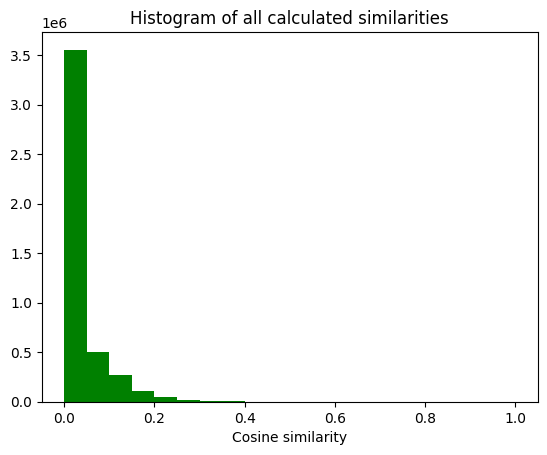

In [74]:
ds = []
for n1,n2,d in G1.edges(data=True):
  for l in d['dist']:
    ds += l
print("Total number of calculated similarities",len(ds))
print(ds[:5])
da = np.array(ds, dtype='float64')
print(np.mean(da))
print("Number of sentence pairs whose similarity is 0:", np.sum(da == 0))
print("Number of sentence pairs whose similarity is 1:", np.sum(da == 1))
print("Proportion of calculated similarities that are 0:", np.sum(da == 0)/len(ds))
n, bins, patches = plt.hist(ds, bins=20, range=(0,1), facecolor='g')

plt.xlabel('Cosine similarity')
plt.ylabel('')
plt.title('Histogram of all calculated similarities')
plt.show()

99703
[0.0, 0.11952286093343936, 0.2721655269759087, 0.0, 0.14907119849998599]
0.12260521409077843


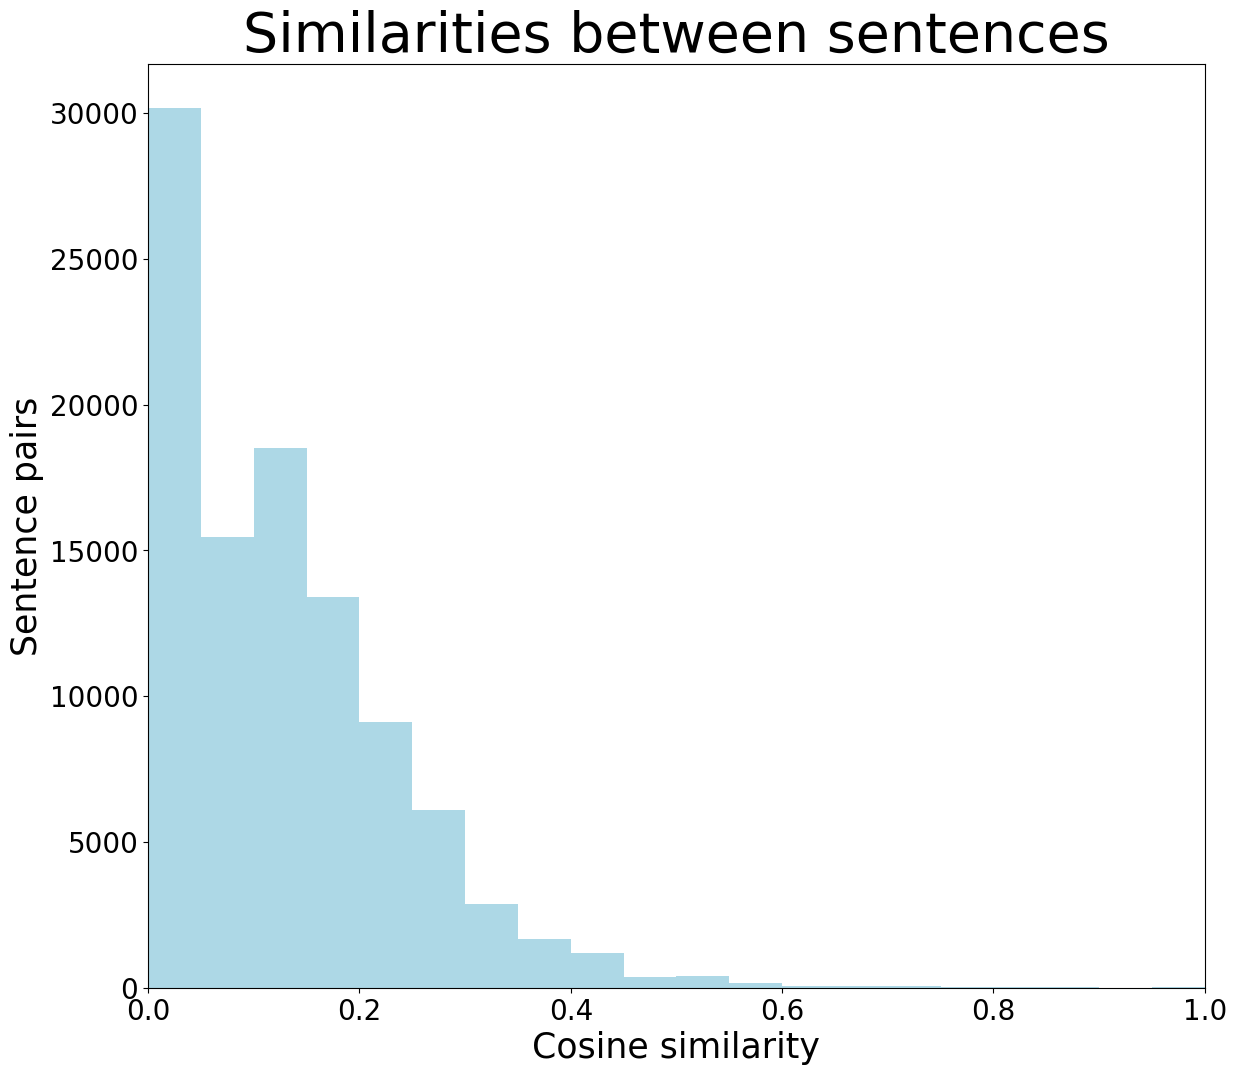

In [75]:
# Sum of maximum mention sentence similarities for each MP pair
ds = []
for n1,n2,d in G1.edges(data=True):
  summax = 0
  for l in d['dist']:
    maxl = np.max(l)
    ds.append(maxl)
    summax += maxl
  G1.edges[n1,n2]['max_weight'] = summax

print(len(ds))
print(ds[:5])
da = np.array(ds, dtype='float64')
print(np.mean(da))


fig = plt.figure(figsize=[30.0, 12.0])
ax1 = fig.add_subplot(1,2,1)

n, bins, patches = ax1.hist(ds, bins=20, range=(0,1), facecolor='lightblue')
ax1.set_title("Similarities between sentences",fontdict={'fontsize':40})
ax1.set_xlabel('Cosine similarity', fontdict={'fontsize':25})
ax1.set_ylabel('Sentence pairs', fontdict={'fontsize':25})
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.autoscale(enable=True, axis='x', tight=True)


In [76]:
print(np.max(da))
print(np.sum(da==0))
print(np.sum(da==1))
print(np.mean(da))

1.0
28134
11
0.12260521409077843


99703
[0.0, 0.00373508940416998, 0.06558289437460699, 0.0, 0.02804912276881871]
0.024456843000027904


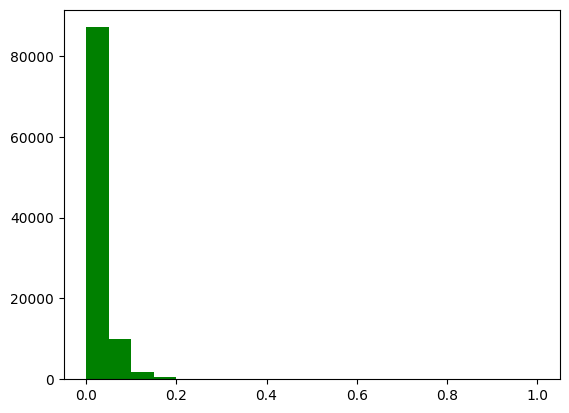

In [77]:
# Sum of average mention sentence similarities for each MP pair
ds = []
for n1,n2,d in G1.edges(data=True):
  md = 0
  summean = 0
  for l in d['dist']:
    lmean = np.mean(l)
    if lmean > md:
      md = lmean
    summean += lmean
    ds.append(lmean)

  G1.edges[n1,n2]['mean_weight'] = summean
print(len(ds))
print(ds[:5])
da = np.array(ds, dtype='float64')
print(np.mean(da))
n, bins, patches = plt.hist(ds, bins=20, range=(0,1), facecolor='g')

plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.show()

In [78]:
print(np.max(da))
print(np.sum(da==0))
print(np.sum(da==1))
print(np.mean(da))

1.0
28134
1
0.024456843000027904


### Degree

In [79]:
dct = G1.degree(weight='max_weight')
set_stats_and_ranks(G1, dct, 'degree_maxw')

arr = sorted(dct, key=lambda x: x[-1], reverse=True)
for v,u in arr[:15]:
  print(u, v, G.nodes[v])

585.9218104357964 http://ldf.fi/semparl/people/p967 {'name': 'Heinonen, Timo', 'party': 'Kansallinen Kokoomus', 'color': '#00587C', 'gcolor': 'lightblue', 'in_degree': 887, 'bow_in': {'aina': 21, 'oieta': 4, 'mieli': 47, 'sananvapaus': 2, 'rajoittaa': 3, 'koskea': 8, 'oma': 20, 'korottaa': 3, 'ehtiä': 3, 'hyvänen': 1, 'aika': 47, 'raiskaus': 3, 'rangaistusasteikko': 1, 'minimitaso': 1, 'voi': 36, 'yhtyä': 10, 'puhe': 15, 'tosi': 65, 'surullinen': 2, 'usea': 12, 'odottaa': 7, 'täydellinen': 1, 'eduskunta': 23, 'tehtävä': 9, 'toteuttaa': 1, 'henki': 4, 'kuten': 59, 'keskustelu': 48, 'tulla': 61, 'esillä': 76, 'oikea': 31, 'halu': 7, 'ymmärtää': 16, 'kysymys': 48, 'ihan': 31, 'keskustella': 5, 'asia': 100, 'syy': 4, 'takia': 12, 'entinen': 4, 'perussuomalainen': 8, 'sininen': 2, 'arvopohjaero': 1, 'iso': 9, 'selkeä': 4, 'heinonen': 22, 'pitää': 42, 'huoli': 14, 'vuo': 20, 'luottaa': 5, 'lakialoite': 33, 'tehnyt': 3, 'vaalikausi': 7, 'korjata': 9, 'ennen': 8, 'kukko': 1, 'kolme': 3, 'laula

In [80]:
arr = sorted(dct, key=lambda x: x[-1])
for v,u in arr[:15]:
  print(u, G.nodes[v])

155.1036251652089 {'name': 'Stubb, Alexander', 'party': 'Kansallinen Kokoomus', 'color': '#00587C', 'gcolor': 'lightblue', 'in_degree': 534, 'bow_in': {'sanoa': 78, 'ensimmäinen': 8, 'ratkaisu': 3, 'synnytty': 1, 'jono': 1, 'terveyskeskus': 1, 'hävitä': 1, 'haluta': 30, 'kysyä': 49, 'voida': 24, 'yksinkertainen': 1, 'vastata': 9, 'pakkolakipaketti': 2, 'vaikutus': 1, 'miten': 30, 'tulla': 40, 'vaikuttaa': 5, 'verotulo': 5, 'budjetti': 5, 'eteenpäin': 9, 'taloussuunnitelma': 1, 'aivan': 13, 'tosi': 25, 'juuri': 18, 'tapa': 18, 'toimia': 10, 'ministeriö': 3, 'asia': 45, 'valmistella': 8, 'kuitenkin': 11, 'kolme': 6, 'kerrata': 7, 'kysynyt': 6, 'keskustelu': 20, 'aika': 33, 'ecofinissä': 1, 'mieli': 17, 'miljoona': 14, 'euro': 13, 'liikevaihtoraja': 1, 'alempi': 1, 'raja': 2, 'voi': 22, 'hyväksyä': 7, 'pyytää': 7, 'esitetty': 1, 'kysymys': 32, 'laskelma': 4, 'tarkoittaa': 2, 'suositella': 2, 'vuosiloma': 1, 'leikata': 16, 'puhua': 34, 'usea': 17, 'velkaantua': 5, 'pahanen': 1, 'pitää': 34

In [81]:
empty_edges = []
for n1,n2,d in G1.edges(data=True):
  if d['max_weight'] == 0:
    empty_edges.append((n1,n2,d))
print("Number of edges whose weight is 0:", len(empty_edges))

Number of edges whose weight is 0: 0


In [82]:
#pos_draw = nx.drawing.layout.kamada_kawai_layout(G2, weight='weight')
pos_draw = nx.drawing.layout.fruchterman_reingold_layout(G1, weight='max_weight', iterations=200)

2926
[('http://ldf.fi/semparl/people/p1116', 'http://ldf.fi/semparl/people/p1094', {'dist': [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11952286093343936, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.12909944487358055, 0.2721655269759087, 0.23570226039551587, 0.0, 0.0, 0.0, 0.0, 0.1889822365046136, 0.11952286093343936, 0.1259881576697424, 0.1091089451179962, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2672612419124244, 0.1543033499620919, 0.0, 0.0, 0.0, 0.0, 0.08219949365267865, 0.05198752449100364, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.035533452725935076, 0.0, 0.0, 0.06804138174397717, 0.07559289460184544, 0.0, 0.06666666666666667, 0.0, 0.0, 0.0, 0.0, 0.1414213562373095, 0.14907119849998599, 0.0, 0.0, 0.05270462766947299, 0.0, 0.0, 0.0], [0.06262242910851495, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05063696835418333, 0.22645540682891915, 0.17118419700436516, 0.0, 0.0, 0.0, 0.0716114874039433, 0.10675210253672476

<ipython-input-4-15930106a6e2>:36: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.drawing.draw_networkx_edges(G,
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


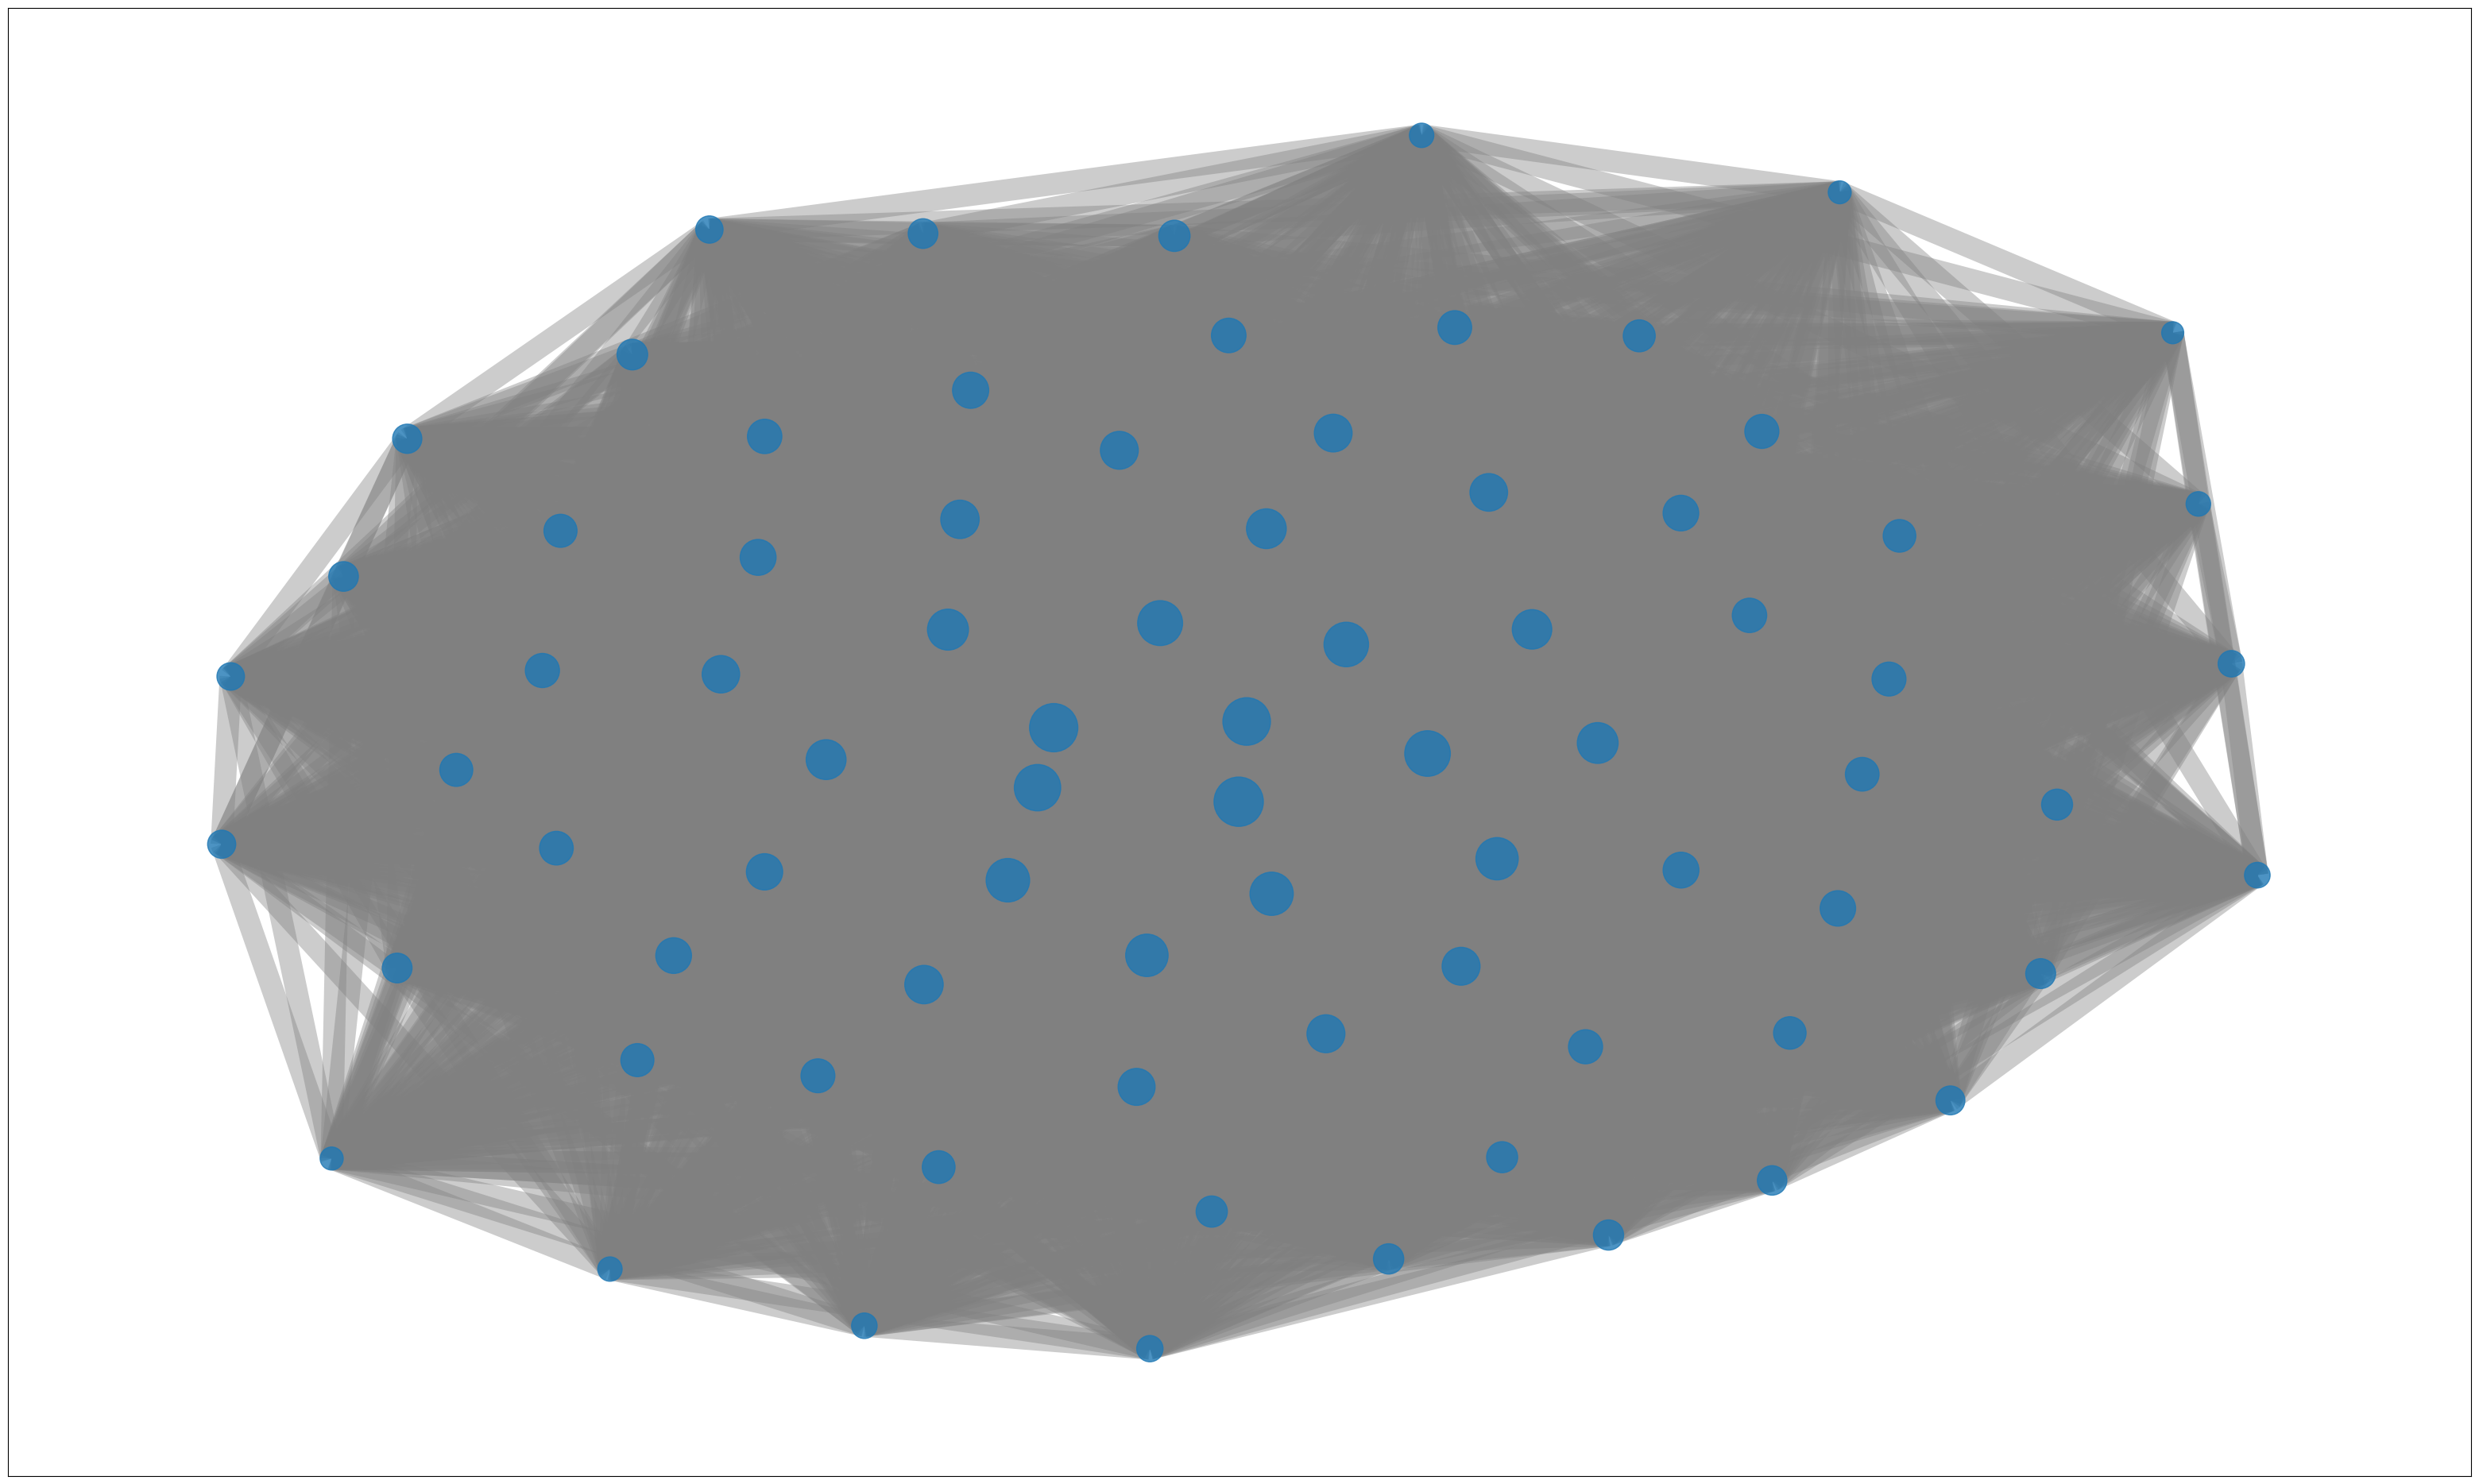

In [83]:
print(len(G1.edges))
print(list(G1.edges(data=True))[:5])
pos_draw = drawGraph(G1,
                    pos=pos_draw,
                    node_size='degree_maxw') # size by # of mentions)
                    #labels = dict([(u, G2.nodes[u]['label']) for u in G2.nodes()]), # uncomment to see MP names
                    #node_color=[gov_colors[e['group']] for _,e in G1.nodes(data=True)])


### Create co-mention/bibliograhical coupling matrix

Replace diagonal with column means

In [84]:
node_labels = [d['name'] for _,d in G1.nodes(data=True)]
C = nx.adjacency_matrix(G1, weight='max_weight')
C = np.asarray(C.todense())
np.fill_diagonal(C,np.nan)
diagonal = np.nanmean(C, axis=0)
np.fill_diagonal(C,diagonal)
df = pd.DataFrame(C, columns=node_labels, index=node_labels)
#idx = df.sum(axis=1).head(30).index
#C3 = df.loc[mentioner_labels,mentioner_labels].to_numpy()
df

,"Tolppanen, Maria","Eestilä, Markku","Sipilä, Juha","Elomaa, Ritva","Hassi, Satu","Skinnari, Ville","Kankaanniemi, Toimi","Kari, Mika","Pakkanen, Markku","Orpo, Petteri",...,"Kiljunen, Anneli","Taavitsainen, Satu","Mikkonen, Krista","Sarkkinen, Hanna","Karimäki, Johanna","Lintilä, Mika","Kurvinen, Antti","Eerola, Juho","Filatov, Tarja","Östman, Peter"
"Tolppanen, Maria",2.833972,2.659468,2.710132,4.025578,2.603284,2.094764,3.293491,2.550572,2.208593,4.452781,...,2.462447,1.941472,2.604830,1.770644,2.272983,2.166211,2.554548,1.427736,2.591255,2.810526
"Eestilä, Markku",2.659468,3.795720,4.750297,3.776565,5.682174,3.087558,4.410841,4.218096,2.940162,4.190882,...,2.052772,1.850956,3.989279,2.081860,3.015529,2.350252,4.699262,1.613955,3.029257,3.435549
"Sipilä, Juha",2.710132,4.750297,4.291524,5.328110,4.193475,2.883304,5.873749,3.417084,3.058073,5.987679,...,2.044759,2.164117,4.568751,1.348216,2.925329,3.846024,3.094695,1.951243,1.757342,3.059936
"Elomaa, Ritva",4.025578,3.776565,5.328110,4.922315,5.344957,3.957351,6.741956,4.973269,5.319302,5.573014,...,3.459948,2.733489,5.036505,2.913900,3.893303,2.944387,5.053142,3.079785,2.840191,4.182410
"Hassi, Satu",2.603284,5.682174,4.193475,5.344957,4.805207,3.944184,5.509224,5.577620,4.349437,5.193841,...,3.762774,2.801991,6.195333,2.796433,4.502250,2.302550,5.360137,1.736434,3.314431,3.398434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Lintilä, Mika",2.166211,2.350252,3.846024,2.944387,2.302550,2.013893,2.723533,1.741431,1.575204,3.933387,...,0.911891,0.844504,1.901363,0.964117,1.204139,2.156735,1.420915,0.762028,1.717809,1.240973
"Kurvinen, Antti",2.554548,4.699262,3.094695,5.053142,5.360137,3.570978,6.526357,4.379668,4.310746,5.754002,...,2.850256,2.629971,4.175326,1.604982,3.019853,1.420915,4.440738,2.246553,3.764156,3.984851
"Eerola, Juho",1.427736,1.613955,1.951243,3.079785,1.736434,1.512606,2.759860,2.695112,1.590495,2.217337,...,1.742848,1.571748,2.209496,1.118911,1.107276,0.762028,2.246553,2.357706,1.389435,2.154923
"Filatov, Tarja",2.591255,3.029257,1.757342,2.840191,3.314431,2.633086,3.913152,4.568259,2.537186,2.803819,...,2.978870,2.199968,3.240075,1.504718,2.129424,1.717809,3.764156,1.389435,3.196080,2.566261


### MDS

In [85]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise

In [86]:
df_cosC = pd.DataFrame(pairwise.cosine_similarity(C), columns=node_labels, index=node_labels)
#idx = df.sum(axis=1).head(30).index
#C3 = df.loc[mentioner_labels,mentioner_labels].to_numpy()
#df_cosC.to_csv('Bib_sisalto_kosini.csv')
df_corC = pd.DataFrame(np.corrcoef(C), columns=node_labels, index=node_labels)
#idx = df.sum(axis=1).head(30).index
#C3 = df.loc[mentioner_labels,mentioner_labels].to_numpy()
#df_corC.to_csv('Bib_sisalto_pearson.csv')

In [87]:
df_corC

,"Tolppanen, Maria","Eestilä, Markku","Sipilä, Juha","Elomaa, Ritva","Hassi, Satu","Skinnari, Ville","Kankaanniemi, Toimi","Kari, Mika","Pakkanen, Markku","Orpo, Petteri",...,"Kiljunen, Anneli","Taavitsainen, Satu","Mikkonen, Krista","Sarkkinen, Hanna","Karimäki, Johanna","Lintilä, Mika","Kurvinen, Antti","Eerola, Juho","Filatov, Tarja","Östman, Peter"
"Tolppanen, Maria",1.000000,0.808173,0.715509,0.796875,0.799737,0.819868,0.836351,0.822259,0.788491,0.774649,...,0.785324,0.755370,0.756427,0.777357,0.727895,0.697214,0.783755,0.782656,0.801992,0.790630
"Eestilä, Markku",0.808173,1.000000,0.784344,0.854385,0.903617,0.844750,0.876364,0.840968,0.876632,0.825904,...,0.770227,0.755389,0.879337,0.747410,0.829330,0.733313,0.870517,0.772826,0.764321,0.800928
"Sipilä, Juha",0.715509,0.784344,1.000000,0.774951,0.774621,0.743473,0.785762,0.700780,0.796073,0.863354,...,0.667129,0.582408,0.714983,0.644281,0.689751,0.805419,0.801519,0.750102,0.639692,0.731858
"Elomaa, Ritva",0.796875,0.854385,0.774951,1.000000,0.864403,0.859675,0.882757,0.856490,0.866418,0.827812,...,0.795591,0.784081,0.851192,0.792004,0.813249,0.640762,0.876177,0.819738,0.808080,0.860608
"Hassi, Satu",0.799737,0.903617,0.774621,0.864403,1.000000,0.878317,0.864452,0.851869,0.853755,0.795440,...,0.788278,0.800630,0.901930,0.838923,0.876555,0.649284,0.882718,0.789849,0.817837,0.842144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Lintilä, Mika",0.697214,0.733313,0.805419,0.640762,0.649284,0.630224,0.700181,0.578812,0.684885,0.809849,...,0.518095,0.421901,0.586016,0.499700,0.522665,1.000000,0.669346,0.624345,0.519074,0.570787
"Kurvinen, Antti",0.783755,0.870517,0.801519,0.876177,0.882718,0.842225,0.852235,0.886535,0.851386,0.821928,...,0.759225,0.773785,0.860859,0.764375,0.819824,0.669346,1.000000,0.814267,0.785494,0.847053
"Eerola, Juho",0.782656,0.772826,0.750102,0.819738,0.789849,0.757853,0.827401,0.765670,0.775572,0.780536,...,0.761147,0.713509,0.752088,0.743975,0.738888,0.624345,0.814267,1.000000,0.761419,0.851972
"Filatov, Tarja",0.801992,0.764321,0.639692,0.808080,0.817837,0.816745,0.811435,0.858310,0.748023,0.697092,...,0.840348,0.827243,0.783819,0.797458,0.773072,0.519074,0.785494,0.761419,1.000000,0.847173


In [88]:
embedding = MDS(random_state=43, n_components=2, metric=True)#, dissimilarity='precomputed')
distances = 1- (np.corrcoef(C)+1)*0.5
C_transformed = embedding.fit_transform(pairwise.cosine_similarity(C))
#C_transformed = embedding.fit_transform(np.corrcoef(C))

print("Stress:", embedding.stress_)

d = pairwise.euclidean_distances(embedding.embedding_)
print(0.5*np.sum((d-embedding.dissimilarity_matrix_)**2))

## Kruskal's stress
stress1 = np.sqrt(embedding.stress_ / (0.5 * np.sum(embedding.dissimilarity_matrix_**2)))
print("Kruskal's Stress :", stress1)


Stress: 0.5044956736249144
0.5007883820883948
Kruskal's Stress : 0.12112632295221865


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [89]:
R = np.corrcoef(pairwise.euclidean_distances(embedding.embedding_).flatten(), embedding.dissimilarity_matrix_.flatten())[0,1]
print("R-squared", R*R)

R-squared 0.9664847901695658


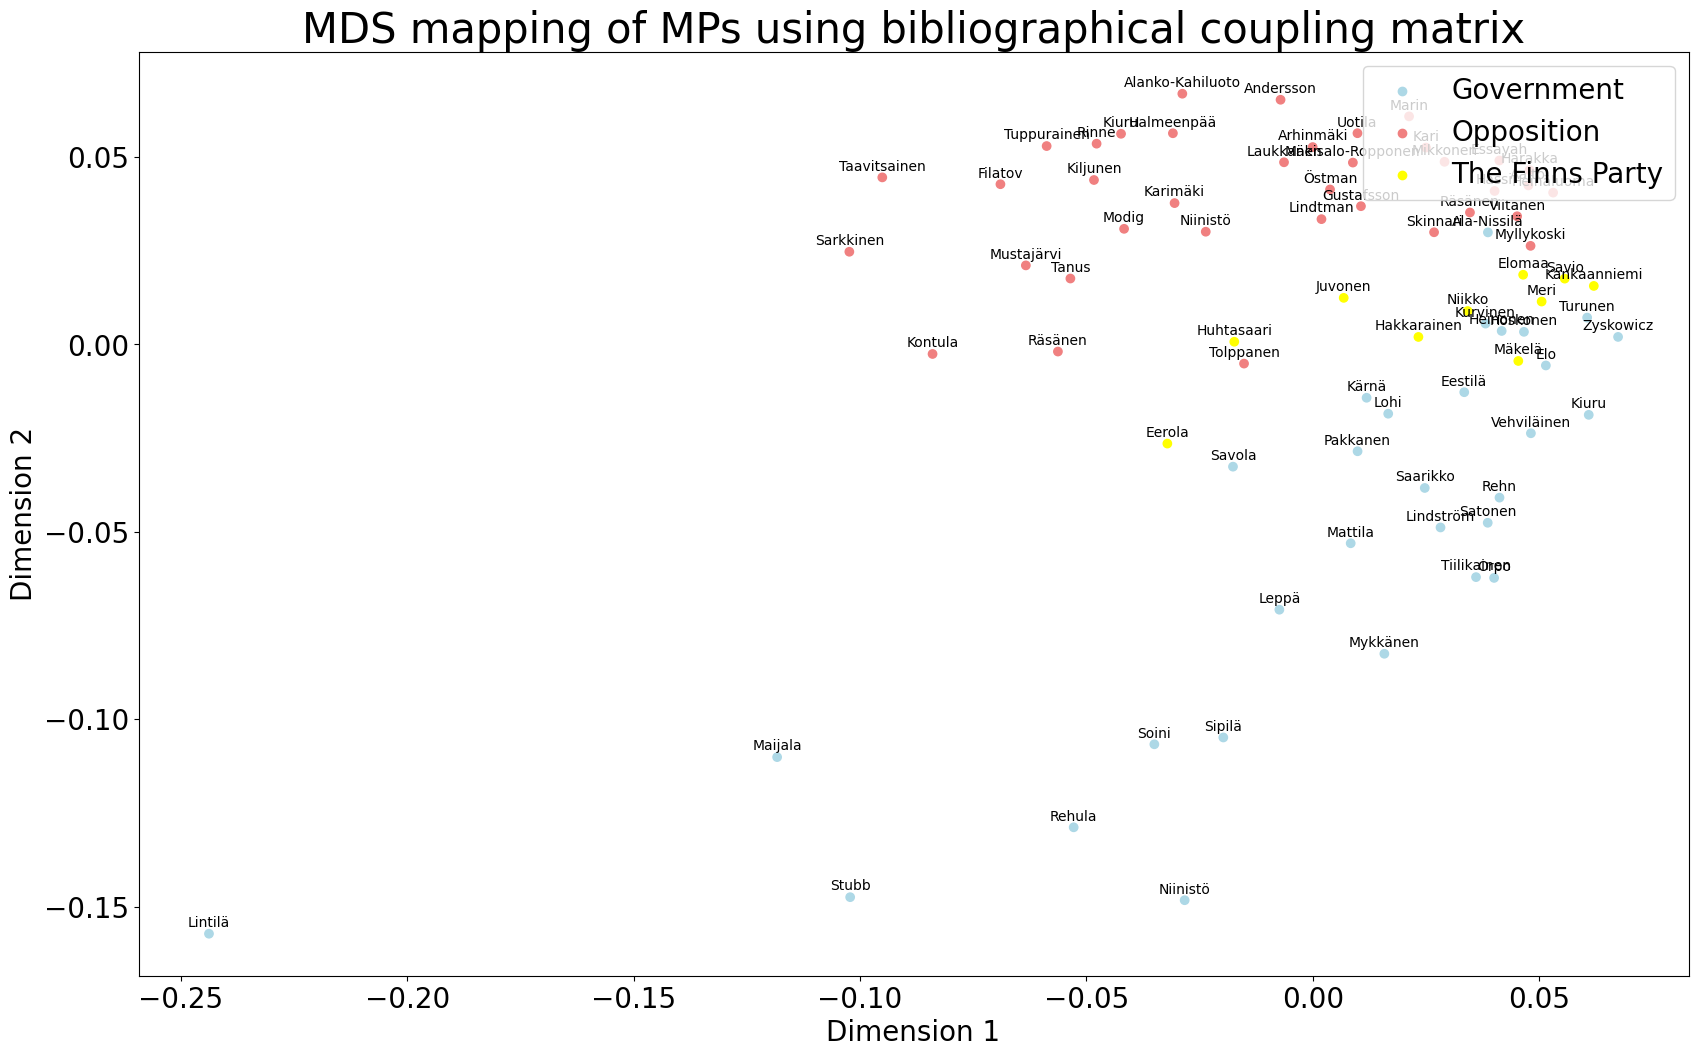

In [90]:
fig = plt.figure(figsize=[20.0, 12.0])
ax = fig.add_subplot(111)


ax.scatter(C_transformed[:,0], C_transformed[:,1], c=[d['gcolor'] for n,d in G1.nodes(data=True)])

names = node_labels #[d['label'].split(" ")[0][:-1] for _,d in G2.nodes(data=True)]
for x,y,i in zip(C_transformed[:,0], C_transformed[:,1], range(C_transformed.shape[0])):
    ax.annotate(names[i].split(" ")[0][:-1], # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.scatter([],[], c='lightblue', label='Government')
plt.scatter([],[], c='lightcoral', label='Opposition')
plt.scatter([],[], c='yellow', label='The Finns Party')




ax.legend(prop={'size': 20},loc='upper right')#, bbox_to_anchor=(1, 0.5))
#plt.xlim([-0.14,0.18])
#plt.ylim([-0.32,0.25])
plt.xlabel('Dimension 1', fontsize=20)
plt.ylabel('Dimension 2', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.title('MDS mapping of MPs using bibliographical coupling matrix', fontsize=30)
plt.show()

### Clustering

In [91]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

In [92]:
correlations = pairwise.cosine_distances(C) #np.corrcoef(C, rowvar=False)
k = 4

In [93]:
kmeans = KMeans(n_clusters=k).fit(correlations)
clabels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [94]:
persons = np.array(G1.nodes(data=True))
for i in range(k):
  print("Group", i+1)
  for person in np.array(node_labels)[clabels==i]:
    #data = G.nodes[person]
    #plabel = data['label'].split(" ")
    #plabel = plabel[0] + plabel[1][0] + "."
    #print("{:30s} {:10s} {:<40s}".format(plabel, '', group_names[data['group']]))
    print(person)
  print()



Group 1
Sipilä, Juha
Soini, Timo
Niinistö, Jussi
Stubb, Alexander
Maijala, Eeva-Maria
Rehula, Juha
Lintilä, Mika

Group 2
Eestilä, Markku
Pakkanen, Markku
Orpo, Petteri
Leppä, Jari
Mykkänen, Kai
Saarikko, Annika
Savola, Mikko
Lohi, Markus
Kiuru, Pauli
Mattila, Pirkko
Kärnä, Mikko
Lindström, Jari
Tiilikainen, Kimmo
Rehn, Olli
Vehviläinen, Anu
Satonen, Arto
Eerola, Juho

Group 3
Tolppanen, Maria
Elomaa, Ritva
Hassi, Satu
Skinnari, Ville
Kankaanniemi, Toimi
Kari, Mika
Huhtasaari, Laura
Uotila, Kari
Myllykoski, Jari
Savio, Sami
Gustafsson, Jukka
Laukkanen, Antero
Ala-Nissilä, Olavi
Mäkisalo-Ropponen, Merja
Arhinmäki, Paavo
Meri, Leena
Hakkarainen, Teuvo
Lindtman, Antti
Elo, Simon
Heinäluoma, Eero
Mäkelä, Jani
Marin, Sanna
Niikko, Mika
Aalto, Touko
Essayah, Sari
Turunen, Kaj
Harakka, Timo
Hoskonen, Hannu
Juvonen, Arja
Räsänen, Joona
Heinonen, Timo
Viitanen, Pia
Zyskowicz, Ben
Mikkonen, Krista
Kurvinen, Antti
Östman, Peter

Group 4
Tuppurainen, Tytti
Rinne, Antti
Räsänen, Päivi
Andersson, Li

In [95]:
clustering = AgglomerativeClustering(n_clusters=k).fit(correlations)
clabels = clustering.labels_

/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [96]:

for i in range(k):
  print("Group", i+1)
  summa = 0
  people = 0
  for person in np.array(node_labels)[clabels==i]:
    print(person)

  print()



Group 1
Sipilä, Juha
Soini, Timo
Niinistö, Jussi
Stubb, Alexander
Maijala, Eeva-Maria
Rehula, Juha
Lintilä, Mika

Group 2
Elomaa, Ritva
Hassi, Satu
Skinnari, Ville
Kankaanniemi, Toimi
Kari, Mika
Uotila, Kari
Myllykoski, Jari
Savio, Sami
Gustafsson, Jukka
Laukkanen, Antero
Ala-Nissilä, Olavi
Mäkisalo-Ropponen, Merja
Arhinmäki, Paavo
Meri, Leena
Hakkarainen, Teuvo
Lindtman, Antti
Elo, Simon
Andersson, Li
Heinäluoma, Eero
Mäkelä, Jani
Kiuru, Pauli
Marin, Sanna
Niikko, Mika
Aalto, Touko
Essayah, Sari
Turunen, Kaj
Alanko-Kahiluoto, Outi
Niinistö, Ville
Harakka, Timo
Vehviläinen, Anu
Hoskonen, Hannu
Juvonen, Arja
Räsänen, Joona
Heinonen, Timo
Viitanen, Pia
Zyskowicz, Ben
Mikkonen, Krista
Kurvinen, Antti
Östman, Peter

Group 3
Tuppurainen, Tytti
Rinne, Antti
Räsänen, Päivi
Kontula, Anna
Modig, Silvia
Mustajärvi, Markus
Tanus, Sari
Kiuru, Krista
Halmeenpää, Hanna
Kiljunen, Anneli
Taavitsainen, Satu
Sarkkinen, Hanna
Karimäki, Johanna
Filatov, Tarja

Group 4
Tolppanen, Maria
Eestilä, Markku
Pakk

<ipython-input-97-57075fb393b5>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(correlations, 'ward')


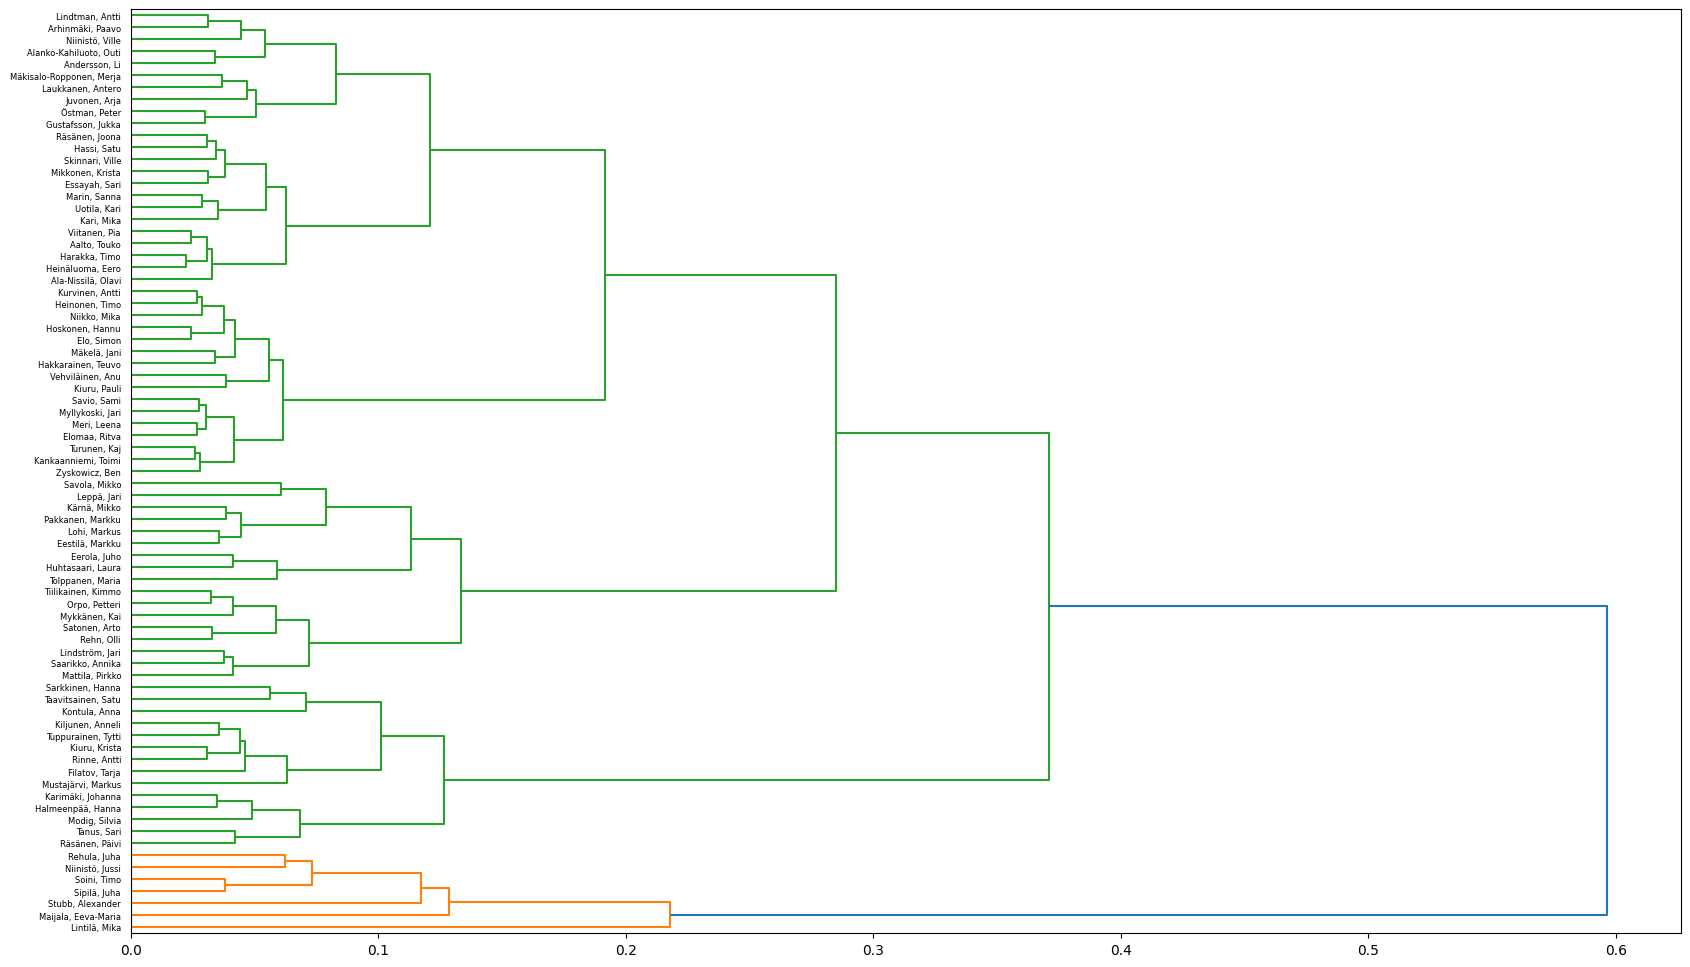

In [97]:
Z = linkage(correlations, 'ward')

plt.figure(figsize=[20.0, 12.0])

dn = dendrogram(Z, labels=node_labels, orientation='right')

### Factor analysis

In [98]:
pip install factor_analyzer

In [99]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo,calculate_bartlett_sphericity

In [110]:
mat_fa = pairwise.cosine_similarity(C)
mat_fa = np.corrcoef(C)
kmo_all,kmo_model=calculate_kmo(mat_fa)
kmo_model

/usr/local/lib/python3.10/dist-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.3036134925498097

In [111]:
mask = kmo_all>0.33
print(np.sum(mask))
np.corrcoef(C[mask]).shape
kmo_all,kmo_model=calculate_kmo(mat_fa)
kmo_model

19


0.3036134925498097

In [112]:
names = np.array([d['name'] for _,d in G1.nodes(data=True)])
names[~mask]

array(['Tolppanen, Maria', 'Eestilä, Markku', 'Sipilä, Juha',
       'Pakkanen, Markku', 'Orpo, Petteri', 'Leppä, Jari',
       'Myllykoski, Jari', 'Soini, Timo', 'Savio, Sami',
       'Niinistö, Jussi', 'Mykkänen, Kai', 'Saarikko, Annika',
       'Gustafsson, Jukka', 'Laukkanen, Antero', 'Savola, Mikko',
       'Stubb, Alexander', 'Mäkisalo-Ropponen, Merja', 'Arhinmäki, Paavo',
       'Rinne, Antti', 'Meri, Leena', 'Hakkarainen, Teuvo',
       'Räsänen, Päivi', 'Elo, Simon', 'Heinäluoma, Eero',
       'Kontula, Anna', 'Mäkelä, Jani', 'Lohi, Markus', 'Kiuru, Pauli',
       'Marin, Sanna', 'Mattila, Pirkko', 'Niikko, Mika',
       'Maijala, Eeva-Maria', 'Kärnä, Mikko', 'Lindström, Jari',
       'Aalto, Touko', 'Turunen, Kaj', 'Tiilikainen, Kimmo',
       'Alanko-Kahiluoto, Outi', 'Harakka, Timo', 'Vehviläinen, Anu',
       'Tanus, Sari', 'Hoskonen, Hannu', 'Juvonen, Arja',
       'Räsänen, Joona', 'Viitanen, Pia', 'Zyskowicz, Ben',
       'Kiuru, Krista', 'Satonen, Arto', 'Halmeenpää, H

In [113]:
fa = FactorAnalyzer(n_factors=len(G.nodes), rotation=None, method='principal')
fa.fit(mat_fa)

FactorAnalyzer(method='principal', n_factors=77, rotation=None,
               rotation_kwargs={})

In [114]:
print(np.sum(fa.get_eigenvalues()[0]>1))
factors = np.sum(fa.get_eigenvalues()[0]>1)
#factors = 5
fa.get_eigenvalues()[0]

5


array([ 3.49698332e+01,  2.30886237e+01,  4.70072138e+00,  3.37986649e+00,
        1.55104713e+00,  9.84980851e-01,  8.60455265e-01,  7.66616449e-01,
        6.49921885e-01,  5.46315890e-01,  4.97254481e-01,  4.59590992e-01,
        4.04124453e-01,  3.86062852e-01,  3.27618685e-01,  2.97006352e-01,
        2.78198411e-01,  2.67487847e-01,  2.49364070e-01,  2.17306471e-01,
        1.96940646e-01,  1.92694308e-01,  1.72775767e-01,  1.70813294e-01,
        1.41843696e-01,  1.32327731e-01,  1.16765315e-01,  1.13526513e-01,
        1.05350969e-01,  8.09988601e-02,  7.81764021e-02,  7.20898009e-02,
        6.45006998e-02,  6.05872320e-02,  5.73436262e-02,  5.02544494e-02,
        4.22362620e-02,  3.92916862e-02,  3.04201214e-02,  2.82290307e-02,
        2.51443765e-02,  1.98720996e-02,  1.72845576e-02,  1.58594331e-02,
        1.42294328e-02,  1.39174694e-02,  1.11258630e-02,  9.31548565e-03,
        8.31005858e-03,  6.16017307e-03,  5.97375325e-03,  4.37454612e-03,
        4.13661397e-03,  

In [115]:
fa = FactorAnalyzer(n_factors=factors, rotation='promax', method='principal')
fa.fit_transform(mat_fa)


array([[ 3.03292605e-01, -7.01291014e-02, -1.17303127e+00,
         3.14525035e-01, -1.58421244e+00],
       [ 4.28229437e-01,  9.79216581e-01,  1.33808031e+00,
        -3.23399267e-01, -8.92584691e-01],
       [-1.83572312e+00,  6.13750210e-01, -1.31885339e+00,
        -1.06581139e+00, -5.31217520e-01],
       [ 4.45942240e-01,  7.34963237e-01,  8.80065326e-01,
         1.27198846e+00,  2.56464883e-02],
       [ 8.90955207e-01,  3.99196418e-01,  1.51430992e+00,
        -1.52901531e-02, -9.66580168e-02],
       [ 6.27255949e-01,  7.89816096e-02,  8.21345238e-01,
         1.02017844e-01, -6.25540903e-01],
       [ 6.38464102e-01,  1.22543283e+00,  5.48819672e-01,
         9.80793397e-01, -2.91738263e-01],
       [ 9.61706670e-01, -1.69822816e-01,  8.09260986e-01,
         5.46008914e-01, -6.23756166e-02],
       [-8.83755252e-02,  7.57136347e-01,  1.05233037e+00,
         3.71460755e-01, -1.42142006e+00],
       [-1.05646553e+00,  1.30134009e+00, -6.44273776e-01,
        -3.39384753e-01

In [116]:
total = np.zeros((1,factors))
for i, person in enumerate(node_labels):
  print("{:40s} {}".format(person, fa.loadings_.round(2)[i]))
  total += (fa.loadings_.round(2)[i] >= 0.3)
print("{:40s} {}".format('Total:', total))

Tolppanen, Maria                         [ 0.85  0.32 -0.44  0.31 -0.34]
Eestilä, Markku                          [ 0.25  0.54  0.65 -0.28 -0.15]
Sipilä, Juha                             [-0.33  0.87 -0.07 -0.01  0.02]
Elomaa, Ritva                            [0.26 0.34 0.32 0.36 0.04]
Hassi, Satu                              [ 0.52  0.07  0.67 -0.21 -0.01]
Skinnari, Ville                          [ 0.58  0.1   0.44  0.01 -0.12]
Kankaanniemi, Toimi                      [0.41 0.66 0.08 0.21 0.  ]
Kari, Mika                               [ 0.68 -0.07  0.3   0.12  0.  ]
Pakkanen, Markku                         [ 0.02  0.48  0.55  0.11 -0.23]
Orpo, Petteri                            [-0.24  0.91 -0.06  0.02 -0.04]
Leppä, Jari                              [-0.27  0.61  0.68 -0.45 -0.14]
Huhtasaari, Laura                        [ 0.27 -0.02 -0.02  0.8  -0.1 ]
Uotila, Kari                             [ 0.95  0.04  0.18 -0.33  0.09]
Myllykoski, Jari                         [0.41 0.34 0.43 0.08

In [117]:
print("Proportional variance:", np.sum(fa.get_factor_variance()[1]))
print(fa.get_factor_variance()[2])
print(fa.get_factor_variance()[0])

Proportional variance: 0.807824274564984
[0.31238518 0.57091818 0.69593344 0.76977019 0.80782427]
[24.05365914 19.90704067  9.62617537  5.68542909  2.93016487]


0.5709181793072949


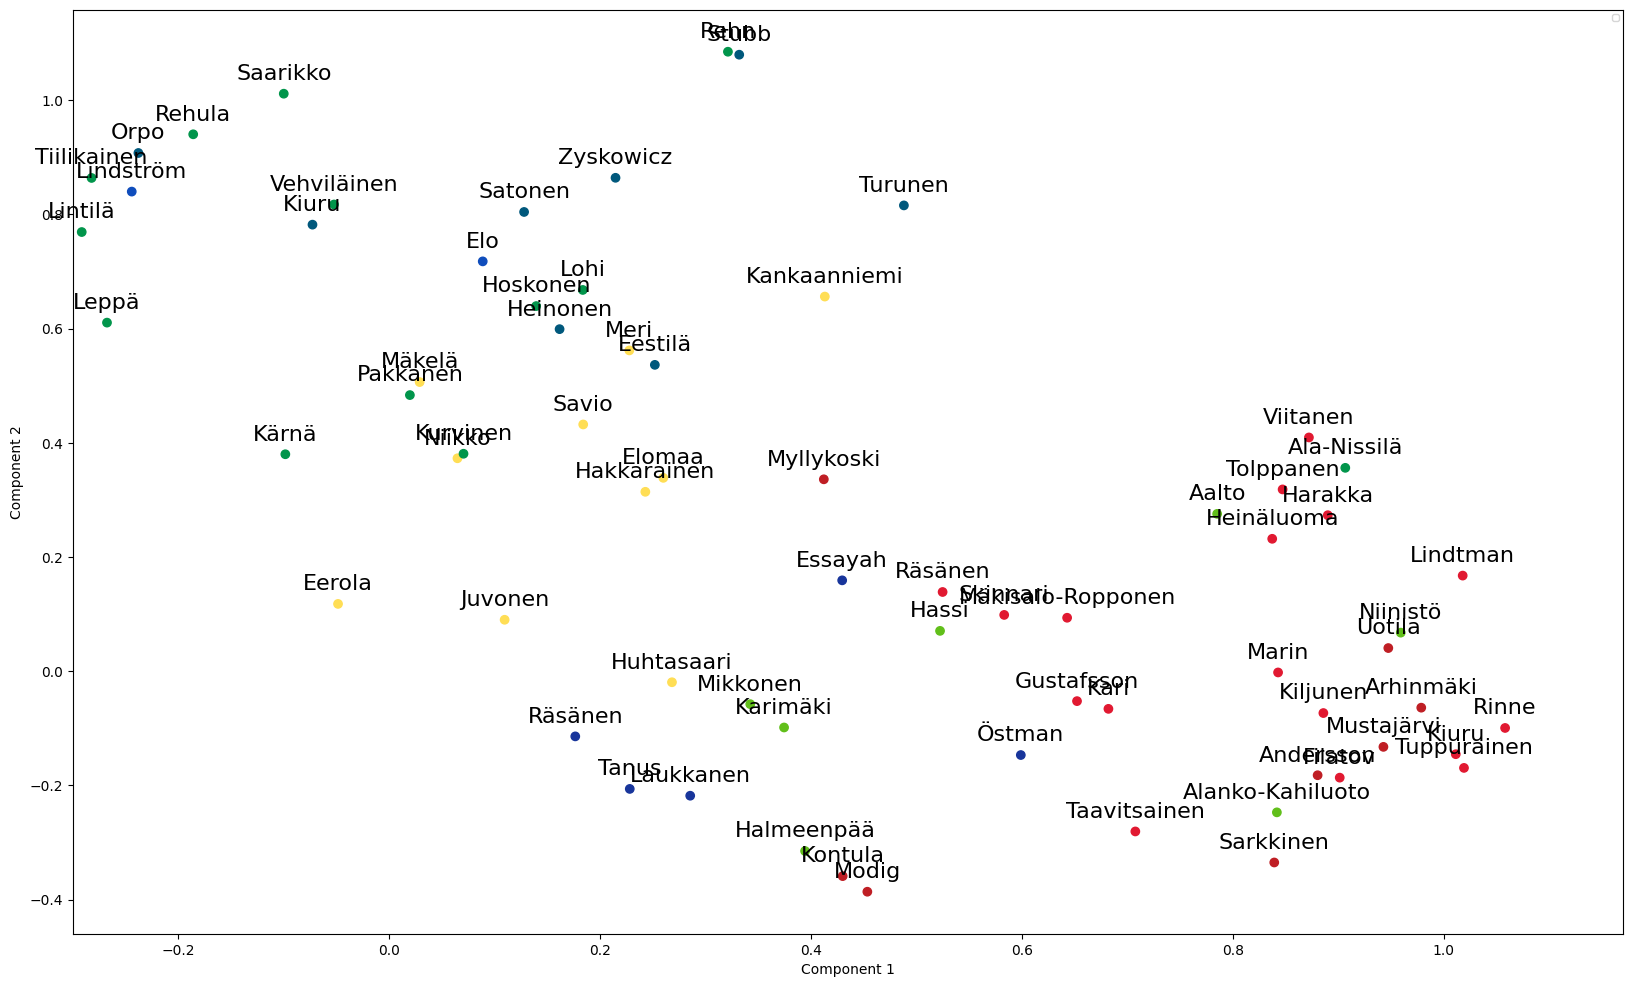

In [118]:
print(np.sum(fa.get_factor_variance()[1][0:2]))
xs = fa.loadings_[:,0]
ys = fa.loadings_[:,1]



fig = plt.figure(figsize=[20.0, 12.0])
ax = fig.add_subplot(111)
ax.scatter(xs,ys, color=[d['color'] for n,d in G.nodes(data=True)])
for x,y,i in zip(xs, ys, range(xs.shape[0])):
    ax.annotate(node_labels[i].split(" ")[0][:-1],
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=16)

plt.legend(prop={'size': 6})
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.xlim([-0.3,1.17])
#plt.ylim([-0.45,0.35])
plt.show()

['http://ldf.fi/semparl/people/p1096']


<ipython-input-4-15930106a6e2>:36: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.drawing.draw_networkx_edges(G,
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


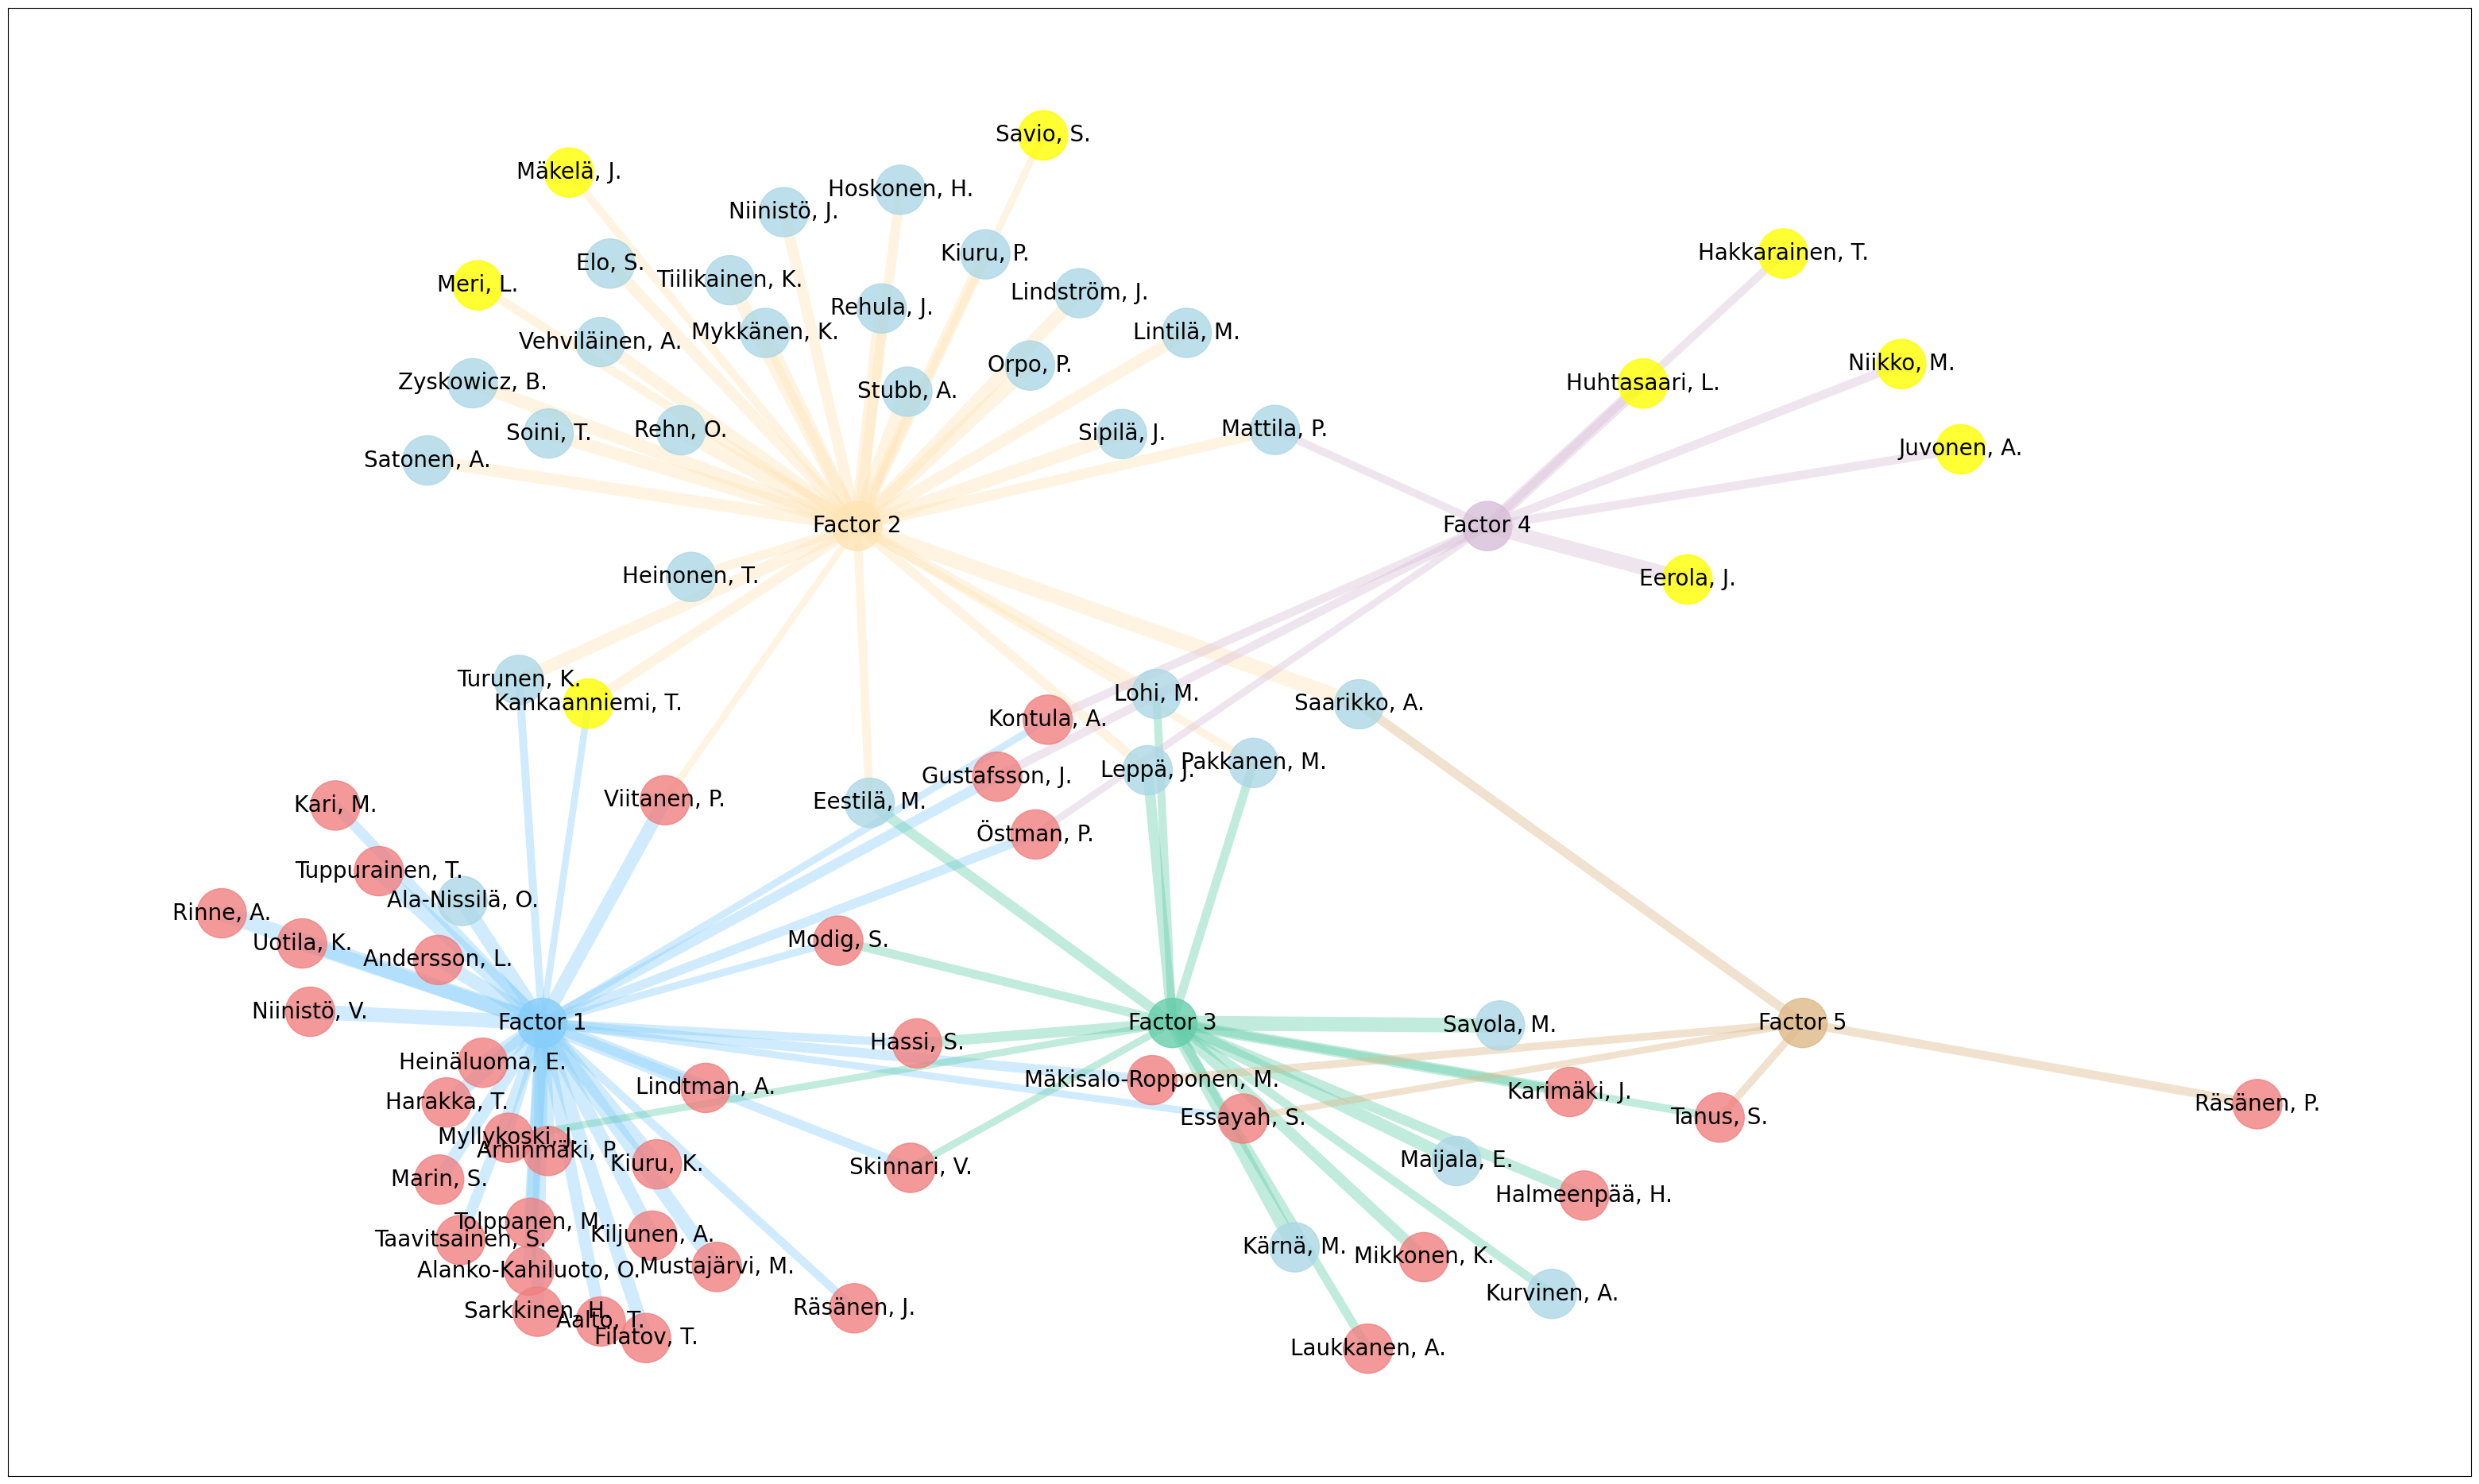

In [119]:
fcolors = ['lightskyblue', 'moccasin', 'mediumaquamarine','thistle','burlywood','lightgrey','darkkhaki','teal']


FG = nx.Graph()
labels = {}
nodes = []
ncolors = []
c_nodes = []
for i in range(factors):
  node = "Factor " + str(i+1)
  FG.add_node(i)
  #colors.append("lightgreen")
  ncolors.append(fcolors[i])
  labels[i] = node
  c_nodes.append(i)

edges = []
mp_nodes = []
for i, (n, data) in enumerate(G1.nodes(data=True)):
  FG.add_node(n)
  mp_nodes.append(n)
  #ncolors.append("blue")
  parts = data["name"].split(" ")#[0][:-1]
  labels[n] = parts[0] + " " + parts[1][0] + "."
  for j in range(factors):
    if fa.loadings_.round(2)[i][j] >= 0.4:
      FG.add_edge(n, j, weight=fa.loadings_.round(2)[i][j], color=fcolors[j])


remove =  [node for node,degree in dict(FG.degree()).items() if degree == 0]
print(remove)
FG.remove_nodes_from(remove)
for r in remove:
  mp_nodes.remove(r)
ncolors += [G1.nodes[n]['gcolor'] for n in mp_nodes]#["yellow"]*(len(FG.nodes())-factors)

for n in remove:
    labels.pop(n, None)

pos = nx.random_layout(FG)
x0 = -4
y0 = -1.5
for n in c_nodes:
  pos[n][0] = x0
  pos[n][1] = y0
  y0 *= -1
  x0 += 1.2


edge_colors = [d['color'] for _,_,d in FG.edges(data=True)]
#pos = graphviz_layout(FG, prog="twopi")
pos = nx.spring_layout(FG, pos=pos, fixed=c_nodes, k=0.5, iterations=20)
pos = drawGraph(FG, pos=pos, labels=labels, node_color=ncolors, edge_color=edge_colors, min_e=0, max_e=1.5)
